In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import *
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from _context import vidlu
from vidlu.utils.presentation.figstyle import configure

In [2]:

#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#matplotlib.rc('font', **{'family': 'serif', 'serif': ['Palatino']})
#rc('text', usetex=True)

#matplotlib.rcParams['mathtext.fontset'] = 'custom'
#matplotlib.rcParams['mathtext.rm'] = 'Palatino'
#matplotlib.rcParams['mathtext.it'] = 'Palatino:italic'
#matplotlib.rcParams['mathtext.bf'] = 'Palatino:bold'

matplotlib.rcParams["figure.dpi"] = 200


get_figsize = configure(document_fontsize=10.95) #, font_package='palatino')

os.makedirs('./data/plots/', exist_ok=True)

###  Memory usage

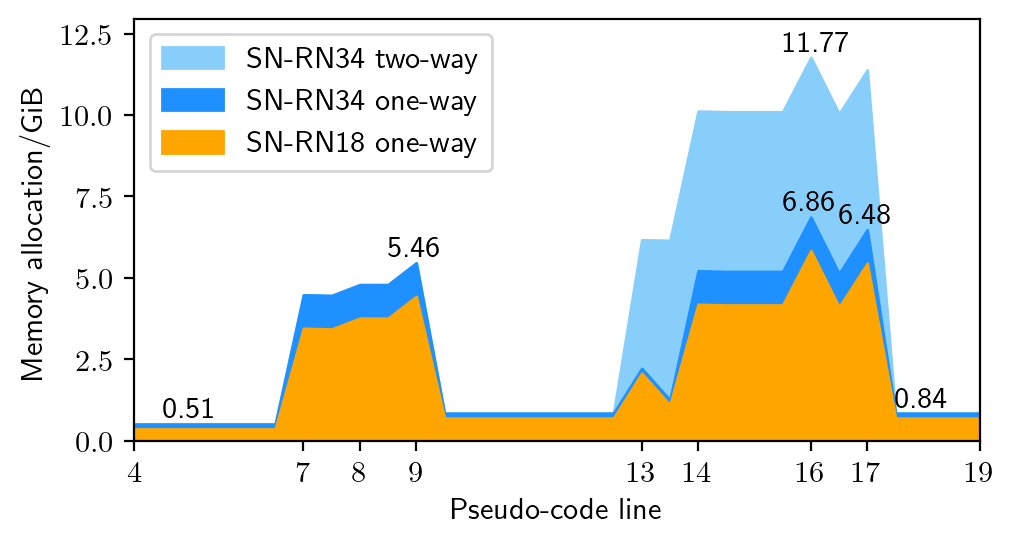

In [3]:
# SN-RN18 448
#x=[3, 3.5, 4, 5, 5.5, 6, 6, 6.5, 7, 7, 7.5, 8, 8, 8.5, 9, 12, 12.5, 13, 13, 13.5, 14, 15, 15.5, 16, 16, 16.5, 17, 18, 18.5, 19, 19, 19.5, 20]
#y=[107.205078125, 107.205078125, 107.205078125, 107.205078125, 107.205078125, 107.205078125, 107.205078125, 1195.3310546875, 1188.0576171875, 1188.0576171875, 1304.43359375, 1304.43359375, 1304.43359375, 1537.18359375, 272.33642578125, 272.33642578125, 754.419921875, 413.21142578125, 413.21142578125, 1502.35302734375, 1495.07958984375, 1495.07958984375, 2076.93896484375, 1484.43994140625, 1484.43994140625, 1954.4404296875, 284.58740234375, 284.58740234375, 284.58740234375, 284.58740234375, 284.58740234375, 402.60107421875, 375.59912109375]

labels = dict(rn18='SN-RN18 one-way', rn34='SN-RN34 one-way', rn34_2w='SN-RN34 two-way')
colors = dict(rn18='orange', rn34='dodgerblue', rn34_2w='lightskyblue')
x = [3, 3.5, 4, 5, 5.5, 6, 6, 6.5, 7, 7, 7.5, 8, 8, 8.5, 9, 12, 12.5, 13, 13, 13.5, 14, 15, 15.5, 16, 16, 16.5, 17, 18,
     18.5, 19]
x = np.array(x)
ys = dict()
# two-way RN34
ys['rn34_2w'] = [517.626953125, 517.626953125, 517.626953125, 517.626953125, 517.626953125, 517.626953125,
                 517.626953125, 4582.9228515625, 4561.5478515625, 4561.5478515625, 4903.548828125, 4903.548828125,
                 4903.548828125, 5587.548828125, 859.62744140625, 859.62744140625, 6314.3427734375, 6296.3134765625,
                 6296.3134765625, 10361.60986328125, 10340.23486328125, 10340.23486328125, 12050.23486328125,
                 10272.73583984375, 10272.73583984375, 11654.236328125, 859.63330078125, 859.63330078125,
                 859.63330078125, 859.63330078125]
# SN-RN34 768
ys['rn34'] = [517.626953125, 517.626953125, 517.626953125, 517.626953125, 517.626953125, 517.626953125, 517.626953125,
              4582.9228515625, 4561.5478515625, 4561.5478515625, 4903.548828125, 4903.548828125, 4903.548828125,
              5587.548828125, 859.62744140625, 859.62744140625, 2270.421875, 1273.62744140625, 1273.62744140625,
              5338.92333984375, 5317.54833984375, 5317.54833984375, 7027.54833984375, 5250.04931640625,
              5250.04931640625, 6631.5498046875, 859.62841796875, 859.62841796875, 859.62841796875, 859.62841796875]
# SN-RN18 768
ys['rn18'] = [363.34765625, 363.34765625, 363.34765625, 363.34765625, 363.34765625, 363.34765625, 363.34765625,
              3528.6142578125, 3507.2392578125, 3507.2392578125, 3849.240234375, 3849.240234375, 3849.240234375,
              4533.240234375, 705.34814453125, 705.34814453125, 2116.134765625, 1119.34814453125, 1119.34814453125,
              4284.61474609375, 4263.23974609375, 4263.23974609375, 5973.23974609375, 4195.74072265625,
              4195.74072265625, 5577.2412109375, 705.34912109375, 705.34912109375, 705.34912109375, 705.34912109375]

for k in ys:
    ys[k] = np.array(ys[k]) / 1024.

w, h = get_figsize(0.9 * 0.9)

fig, ax = plt.subplots(figsize=(w * 1.1, h))


def plotfill(ax, *args, **kwargs):
    ax.fill_between(*args, **kwargs)


for k, label in reversed(labels.items()):
    plotfill(ax, x + 0.5, ys[k], color=colors[k], label=label)  # , transform=rot + base)
#fig.subplots_adjust(left=0, top=1, bottom=0)
plt.xlim(5, 19)
plt.ylim(0, max(max(y) for y in ys.values()) * 1.1)

plt.xticks([4, 7, 8, 9, 13, 14, 16, 17, 19])

ax.set_ylabel(r"Memory allocation/GiB")
ax.set_xlabel(r"Pseudo-code line")
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")
#plt.setp(ax.get_yticklabels(), rotation=90, va="center", ha="left")
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

for xval in [16, 17]:
    yval = ys['rn34'][list(x).index(xval) - 1]
    ax.annotate(f"{yval:.2f}", xy=(xval-0.5, yval+0.2))
for xval in [5, 9, 16, 18]:
    yval = ys['rn34_2w'][list(x).index(xval) - 1]
    ax.annotate(f"{yval:.2f}", xy=(xval-0.5, yval+0.2))
    #a = ax.text(xval, yval, f"{yval:.2f}", bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none'))


plt.legend(loc='upper left')  #, ncol=2)

fig.tight_layout()

fig.savefig('./data/plots/memory-alloc.pdf')

### Half-resolution Cityscapes: teachers, perturbation models, algorithms

In [4]:
def ms(m, s):
    return dict(mean=m, std=s)


def plot_label_subsets(name_to_values, name_to_style, xticks=['$371$', '$743$', '$1487$', '$2975$'],
                       xlabel='Number of labels used', ylabel='$\mathrm{mIoU}/\%$', ylim=None, legend_loc='best',
                       legend_ncol=1, h_mult=1, w_mult=1):
    w, h = get_figsize(0.9)

    fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(w * w_mult, h * h_mult))
    ax1.set_axisbelow(True)
    ax1.grid(color='#eee')

    for name, values in name_to_values.items():
        x = list(range(len(values)))
        style = {'color': 'C0', **name_to_style[name]}
        if isinstance(values[0], dict):
            y = np.array([v['mean'] for v in values])
            stds = np.array([v['std'] for v in values])
            ax1.fill_between(x, y - stds / 2, y + stds / 2, facecolor=style['color'], alpha=0.2,
                             lw=0, interpolate=False)
        else:
            y = values
            backstyle = dict(color='white', linestyle= 'solid', linewidth=3.5)
            backstyle = dict(linestyle= 'solid', alpha=0.2)
            ax1.plot(x, y, **{**style, **backstyle})
        ax1.plot(x, y, **style, label=name)

    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_xticks(range(len(xticks)), xticks)
    if ylim:
        yticks = range(ylim[0], ylim[1] + 1, int((ylim[1] - ylim[0]) / 8 + 0.5))
        ax1.set_yticks(yticks)
        plt.ylim(ylim)
    ax1.legend(loc=legend_loc, ncol=legend_ncol)
    fig.tight_layout()
    return fig

In [5]:
cols = ["Method", "1/8", "1/4", "1/2", "1/1"]
name_to_values = {
    "DLv2-RN101 supervised": [ms(56.4, 0.4), ms(61.9, 1.1), ms(66.6, 0.6), ms(69.8, 0.4)],
    "DLv2-RN101 MT-CutMix*": [ms(63.2, 1.4), ms(65.6, 0.8), ms(67.6, 0.4), ms(70.0, 0.3)],
    "DLv2-RN101 MT-PhTPS": [ms(61.5, 1.0), ms(66.4, 1.1), ms(69.0, 0.6), ms(71.0, 0.7)],
    "SN-RN18 supervised": [ms(55.5, 0.9), ms(61.5, 0.5), ms(66.9, 0.7), ms(70.5, 0.6)],
    "SN-RN18 simple-CutMix": [ms(59.8, 0.5), ms(63.8, 1.2), ms(67.0, 1.4), ms(69.3, 1.1)],
    "SN-RN18 simple-PhTPS": [ms(60.8, 1.6), ms(64.8, 1.5), ms(68.8, 0.7), ms(71.1, 0.9)],
    "SN-RN18 MT-CutMix*": [ms(61.6, 0.9), ms(64.6, 0.5), ms(67.6, 0.7), ms(69.9, 0.6)],
    "SN-RN18 MT-CutMix": [ms(59.3, 1.3), ms(63.3, 1.0), ms(66.8, 0.6), ms(69.7, 0.5)],
    "SN-RN18 MT-PhTPS": [ms(62.0, 1.3), ms(66.0, 1.0), ms(69.1, 0.5), ms(71.2, 0.7)]
}

In [6]:

name_to_style_models = {
    "DLv2-RN101 MT-PhTPS": dict(color='C0', linestyle='dotted'),
    "DLv2-RN101 MT-CutMix*": dict(color='C1', linestyle='dotted'),
    "DLv2-RN101 supervised": dict(color='C2', linestyle='dotted'),
    "SN-RN18 MT-PhTPS": dict(color='C0'),
    "SN-RN18 MT-CutMix*": dict(color='C1'),
    "SN-RN18 supervised": dict(color='C2')
}

name_to_style_ssl = {
    "SN-RN18 simple-PhTPS": dict(color='C0'),
    "SN-RN18 MT-PhTPS": dict(color='C0', linestyle='dotted'),
    "SN-RN18 simple-CutMix": dict(color='C1'),
    "SN-RN18 MT-CutMix": dict(color='C1', linestyle='dotted'),
    "SN-RN18 supervised": dict(color='C2')
}


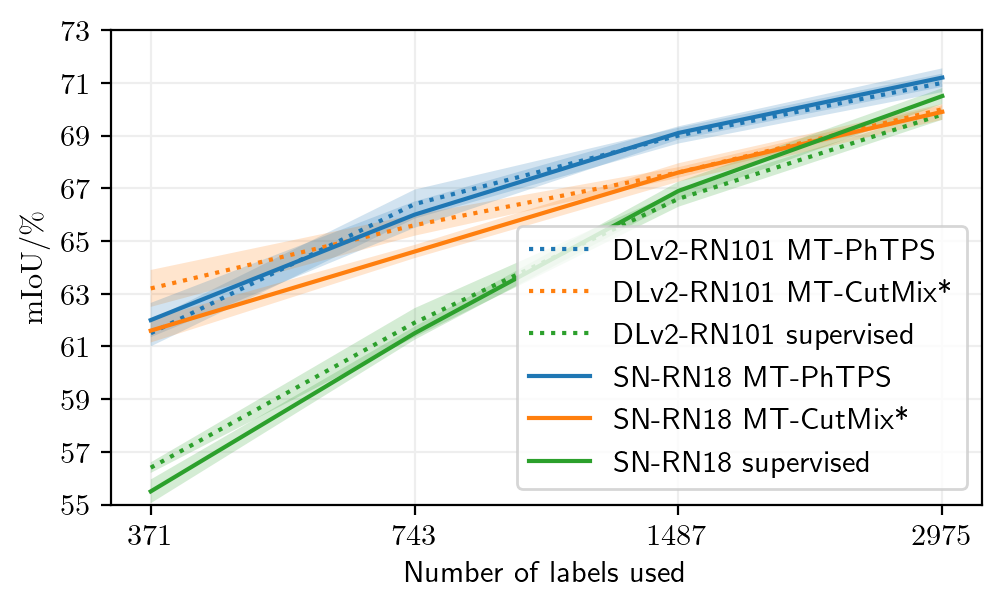

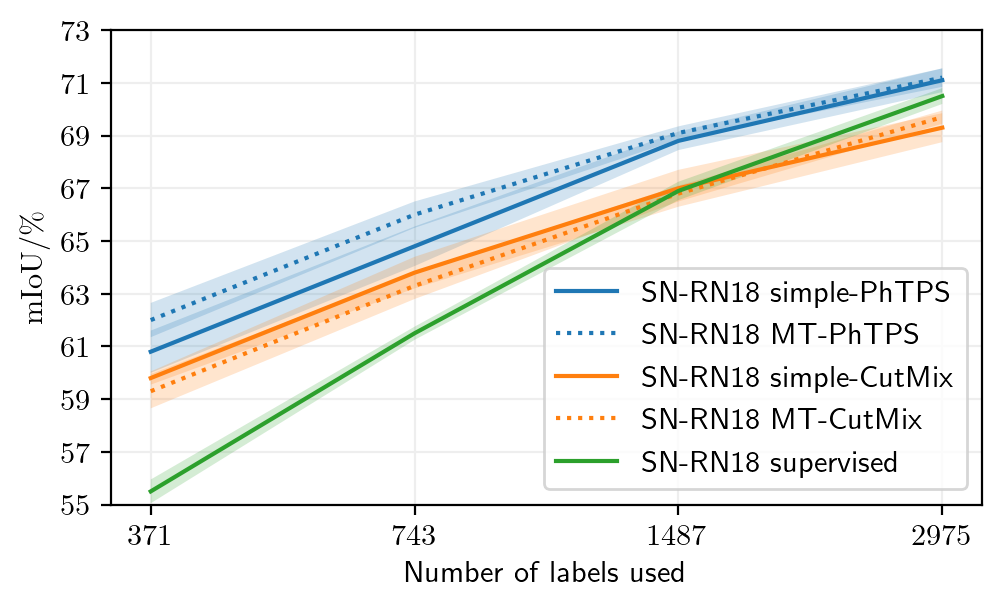

In [7]:

fig = plot_label_subsets({k: name_to_values[k] for k in name_to_style_models.keys()}, name_to_style_models,
                         ylim=[55, 73])
fig.savefig('./data/plots/cs-half-sn-dl.pdf')
fig = plot_label_subsets({k: name_to_values[k] for k in name_to_style_ssl.keys()}, name_to_style_ssl, ylim=[55, 73])
fig.savefig('./data/plots/cs-half-ssl.pdf')

### Half-resolution Cityscapes - perturbation model ablation

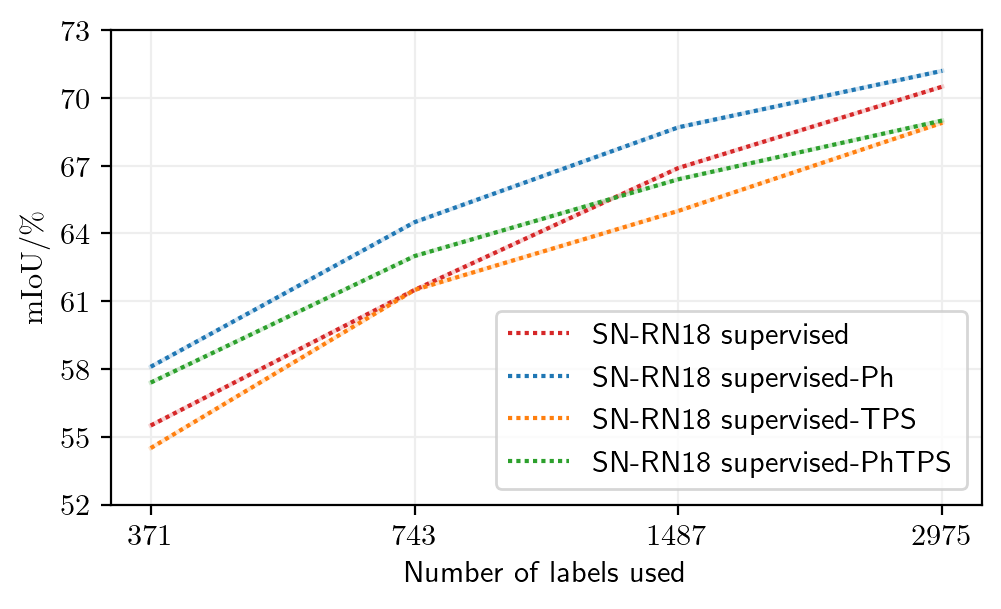

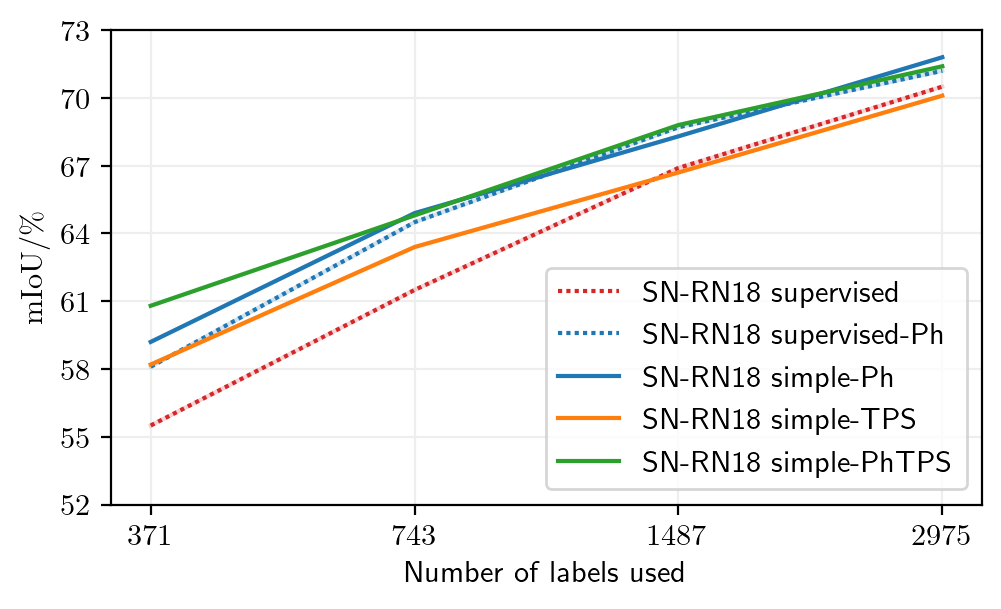

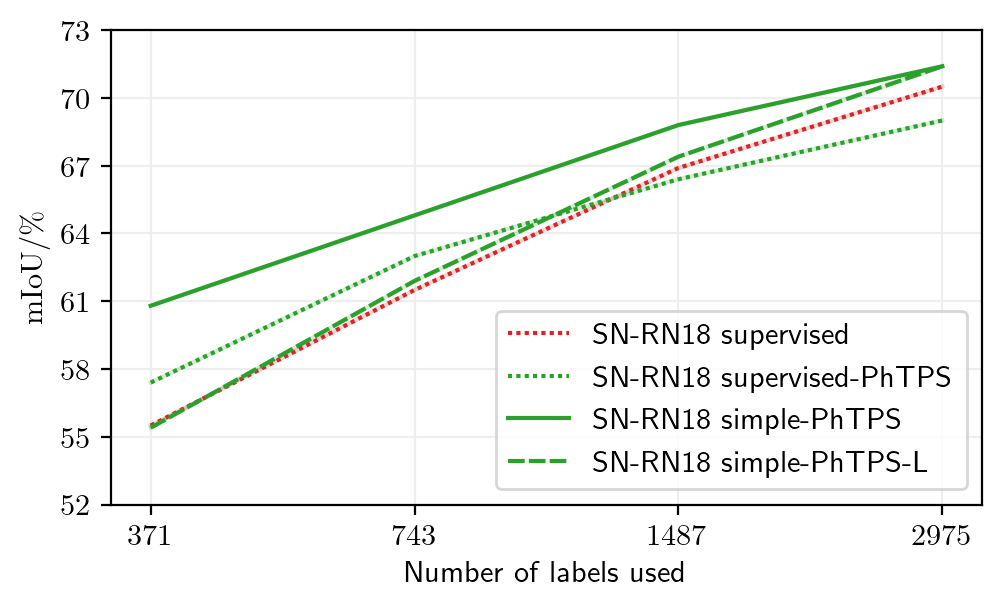

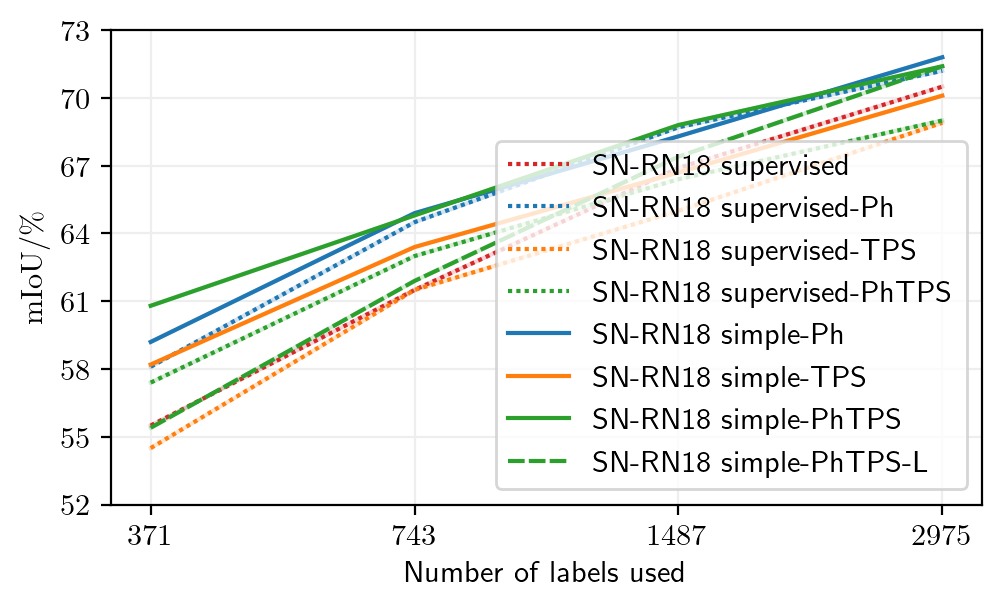

In [8]:
name_to_values = {
    "SN-RN18 supervised": [55.5, 61.5, 66.9, 70.5],
    "SN-RN18 supervised-PhTPS": [57.4, 63.0, 66.4, 69.0],
    "SN-RN18 supervised-Ph": [58.1, 64.5, 68.7, 71.2],
    "SN-RN18 supervised-TPS": [54.5, 61.5, 65.0, 68.9],
    "SN-RN18 simple-Ph": [59.2, 64.9, 68.3, 71.8],
    "SN-RN18 simple-TPS": [58.2, 63.4, 66.7, 70.1],
    "SN-RN18 simple-PhTPS": [60.8, 64.8, 68.8, 71.4],
    "SN-RN18 simple-PhTPS-L": [55.4, 61.9, 67.4, 71.4],
}
dashdotted = (0, (4, 1, 1, 1))
dotted = (0, (1, 1))
dashed = (0, (4, 1))
name_to_style_all = {
    "SN-RN18 supervised": dict(color='tab:red', linestyle=dotted),
    "SN-RN18 supervised-Ph": dict(color='tab:blue', linestyle=dotted),
    "SN-RN18 supervised-TPS": dict(color='tab:orange', linestyle=dotted),
    "SN-RN18 supervised-PhTPS": dict(color='tab:green', linestyle=dotted),
    "SN-RN18 simple-Ph": dict(color='tab:blue'),
    "SN-RN18 simple-TPS": dict(color='tab:orange'),
    "SN-RN18 simple-PhTPS": dict(color='tab:green'),
    "SN-RN18 simple-PhTPS-L": dict(color='tab:green', linestyle=dashed),
}
name_to_style_all_alt = {
    "SN-RN18 supervised": dict(color='tab:blue'),
    "SN-RN18 supervised-Ph": dict(color='tab:blue', linestyle=dashed),
    "SN-RN18 supervised-TPS": dict(color='tab:blue', linestyle=dotted),
    "SN-RN18 supervised-PhTPS": dict(color='tab:blue', linestyle=dashdotted),
    "SN-RN18 simple-Ph": dict(color='tab:orange', linestyle=dashed),
    "SN-RN18 simple-TPS": dict(color='tab:orange', linestyle=dotted),
    "SN-RN18 simple-PhTPS": dict(color='tab:orange', linestyle=dashdotted),
    "SN-RN18 simple-PhTPS-L": dict(color='tab:olive', linestyle=dashdotted),
}
name_to_style_sup = {k: name_to_style_all[k] for k in [
    "SN-RN18 supervised",
    "SN-RN18 supervised-Ph",
    "SN-RN18 supervised-TPS",
    "SN-RN18 supervised-PhTPS"]
}
name_to_style_ss1 = {k: name_to_style_all[k] for k in [
    "SN-RN18 supervised",
    "SN-RN18 supervised-Ph",
    "SN-RN18 simple-Ph",
    "SN-RN18 simple-TPS",
    "SN-RN18 simple-PhTPS"]
}
name_to_style_ss2 = {k: name_to_style_all[k] for k in [
    "SN-RN18 supervised",
    "SN-RN18 supervised-PhTPS",
    "SN-RN18 simple-PhTPS",
    "SN-RN18 simple-PhTPS-L"]
}


for i, nts in enumerate([name_to_style_sup, name_to_style_ss1, name_to_style_ss2, name_to_style_all]):
    fig = plot_label_subsets({k: name_to_values[k] for k in nts}, nts, ylim=[52, 73], h_mult=1)
    fig.savefig(f'./data/plots/cs-half-ablation{i}.pdf')

### Full resolution Cityscapes

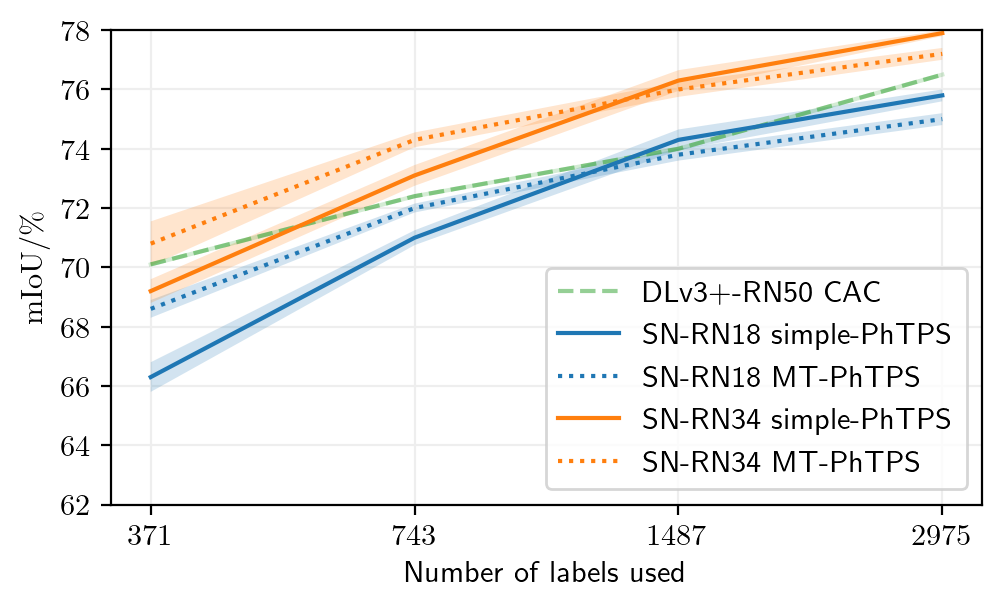

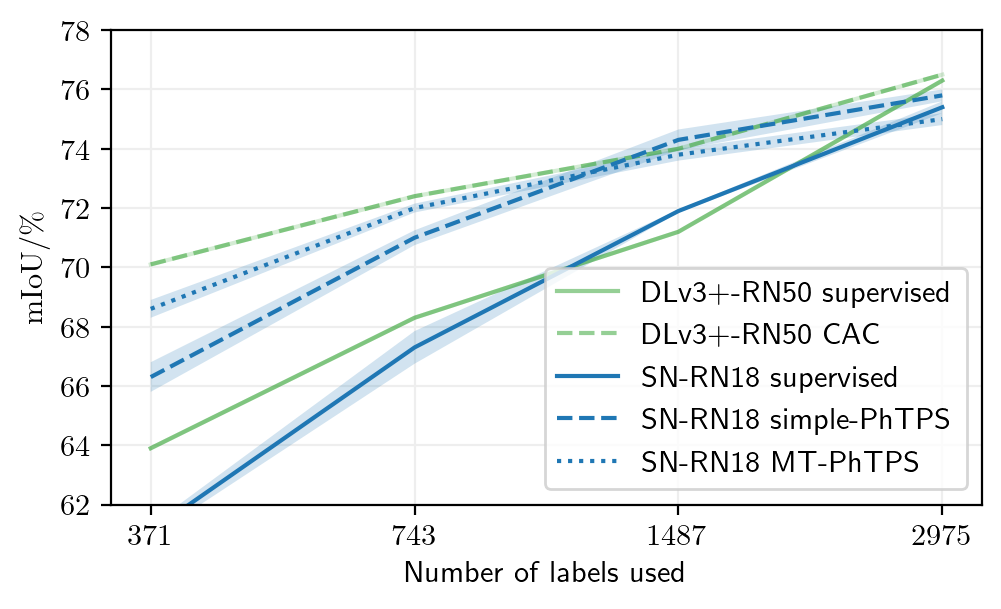

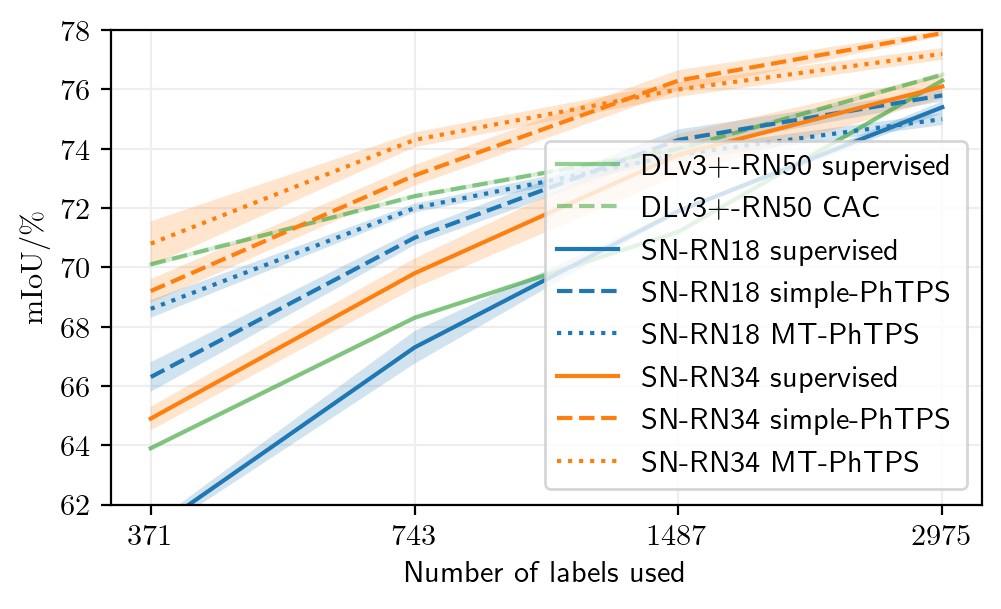

In [9]:
name_to_values = {
    "DLv3+-RN50 supervised": [63.9, 68.3, 71.2, 76.3],
    "DLv3+-RN50 CAC": [70.1, 72.4, 74.0, 76.5],
    "SN-RN18 supervised": [ms(61.1, 0.4), ms(67.3, 1.1), ms(71.9, 0.1), ms(75.4, 0.4)],
    "SN-RN18 simple-PhTPS": [ms(66.3, 1.0), ms(71.0, 0.5), ms(74.3, 0.7), ms(75.8, 0.4)],
    "SN-RN18 MT-PhTPS": [ms(68.6, 0.6), ms(72.0, 0.3), ms(73.8, 0.4), ms(75.0, 0.4)],
    "SN-RN34 supervised": [ms(64.9, 0.8), ms(69.8, 1.0), ms(73.8, 1.4), ms(76.1, 0.8)],
    "SN-RN34 simple-PhTPS": [ms(69.2, 0.8), ms(73.1, 0.7), ms(76.3, 0.7), ms(77.9, 0.2)],
    "SN-RN34 MT-PhTPS": [ms(70.8, 1.5), ms(74.3, 0.5), ms(76.0, 0.5), ms(77.2, 0.4)],
}

name_to_style_dl_sn = {
    "DLv3+-RN50 CAC": dict(color='C2', linestyle='dashed', alpha=0.5),
    "SN-RN18 simple-PhTPS": dict(color='C0'),
    "SN-RN18 MT-PhTPS": dict(color='C0', linestyle='dotted'),
    "SN-RN34 simple-PhTPS": dict(color='C1'),
    "SN-RN34 MT-PhTPS": dict(color='C1', linestyle='dotted'),
}

name_to_style_all = {
    "DLv3+-RN50 supervised": dict(color='C2', alpha=0.5),
    "DLv3+-RN50 CAC": dict(color='C2', linestyle='dashed', alpha=0.5),
    "SN-RN18 supervised": dict(color='C0'),
    "SN-RN18 simple-PhTPS": dict(color='C0', linestyle='dashed'),
    "SN-RN18 MT-PhTPS": dict(color='C0', linestyle='dotted'),
    "SN-RN34 supervised": dict(color='C1'),
    "SN-RN34 simple-PhTPS": dict(color='C1', linestyle='dashed'),
    "SN-RN34 MT-PhTPS": dict(color='C1', linestyle='dotted'),
}

name_to_style1 = {
    "DLv3+-RN50 supervised": dict(color='C2', alpha=0.5),
    "DLv3+-RN50 CAC": dict(color='C2', linestyle='dashed', alpha=0.5),
    "SN-RN18 supervised": dict(color='C0'),
    "SN-RN18 simple-PhTPS": dict(color='C0', linestyle='dashed'),
    "SN-RN18 MT-PhTPS": dict(color='C0', linestyle='dotted'),
}

fig = plot_label_subsets({k: name_to_values[k] for k in name_to_style_dl_sn}, name_to_style_dl_sn, ylim=[62, 78])
fig.savefig('./data/plots/cs-full-ssl.pdf')
#fig = plot_label_subsets({k: name_to_values[k] for k in name_to_style_all}, name_to_style_all, ylim=[62, 78])
#fig.savefig('./data/plots/cs-full2.pdf')

for i, nts in enumerate([name_to_style1, name_to_style_all]):
    fig = plot_label_subsets({k: name_to_values[k] for k in nts}, nts, ylim=[62, 78])
    fig.savefig(f'./data/plots/cs-full{i}.pdf')

### Half-resolution Cityscapes: consistency loss weight $\alpha$ validation

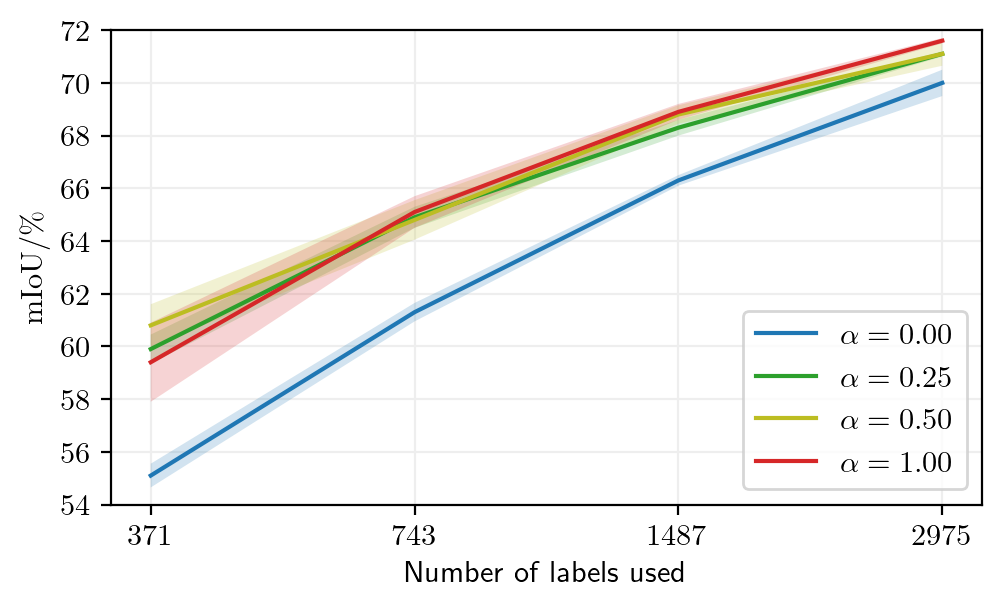

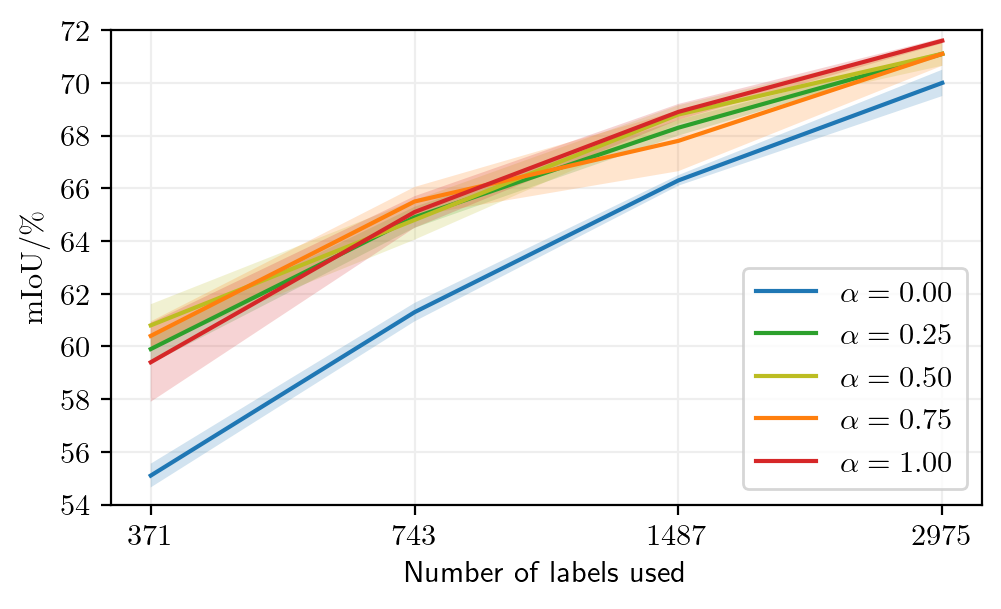

In [10]:
name_to_values = {
    r"$\alpha=0.00$": [ms(55.1, 0.9), ms(61.3, 0.7),
                       ms(66.3, 0.4), ms(70.0, 1.0)],
    r"$\alpha=0.25$": [ms(59.9, 1.1), ms(64.9, 0.8),
                       ms(68.3, 0.6), ms(71.1, 0.2)],
    r"$\alpha=0.50$": [ms(60.8, 1.6), ms(64.8, 1.5),
                       ms(68.8, 0.7), ms(71.1, 0.9)],
    r"$\alpha=0.75$": [ms(60.4, 1.1), ms(65.5, 1.1),
                       ms(67.8, 2.3), ms(71.1, 0.9)],
    r"$\alpha=1.00$": [ms(59.4, 3.0), ms(65.1, 1.2),
                       ms(68.9, 0.6), ms(71.6, 0.2)]}

colors = plt.cm.jet(np.linspace(0, 1, len(name_to_values)))[::-1]

name_to_style = {
    r"$\alpha=0.00$": dict(color='tab:blue'),
    r"$\alpha=0.25$": dict(color='tab:green'),
    r"$\alpha=0.50$": dict(color='tab:olive'),
    r"$\alpha=0.75$": dict(color='tab:orange'),
    r"$\alpha=1.00$": dict(color='tab:red')}

fig = plot_label_subsets({k: v
                          for k, v in name_to_values.items() if '0.75' not in k}, name_to_style,
                         ylim=[54, 72], legend_loc='lower right')
fig = plot_label_subsets(name_to_values, name_to_style,
                         ylim=[54, 72])
fig.savefig('./data/plots/cs-half-ablation-alpha.pdf')

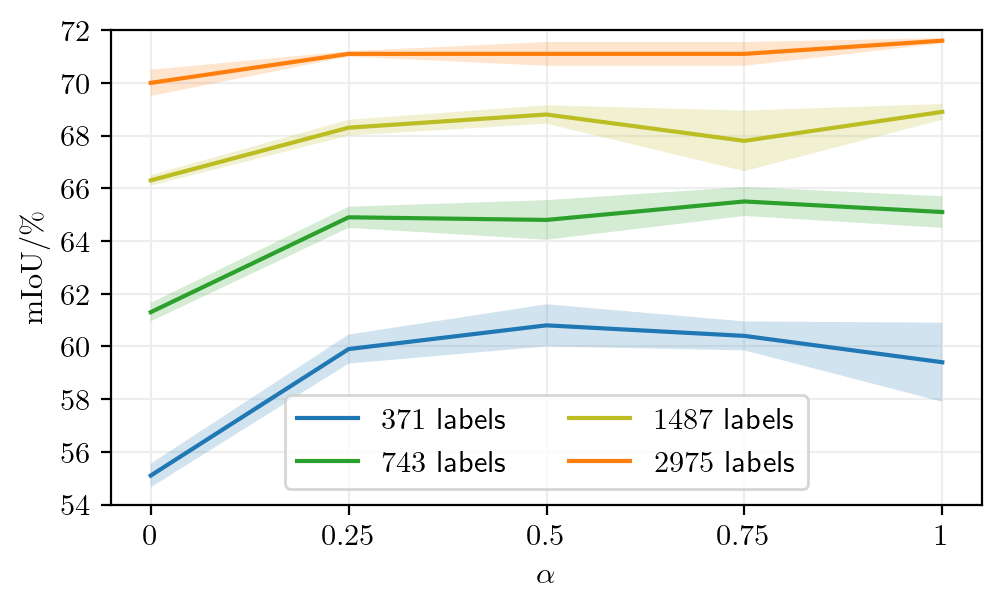

In [11]:

label_proportions = ["$371$ labels", "$743$ labels", "$1487$ labels", "$2975$ labels"]
name_to_values_ = {lp: [name_to_values[k][i] for k in name_to_values] for i, lp in enumerate(label_proportions)}
name_to_style_ = dict(zip(label_proportions, name_to_style.values()))

fig = plot_label_subsets(name_to_values_, name_to_style_, ylim=[54, 72], xlabel=r"$\alpha$",
                         xticks=["$0$", "$0.25$", "$0.5$", "$0.75$", "$1$"], legend_loc='lower center', legend_ncol=2)
fig.savefig('./data/plots/cs-half-ablation-alpha-alt.pdf')

## Batch normalization statistics updating in perturbed students - ablation

### Half-resolution Cityscapes

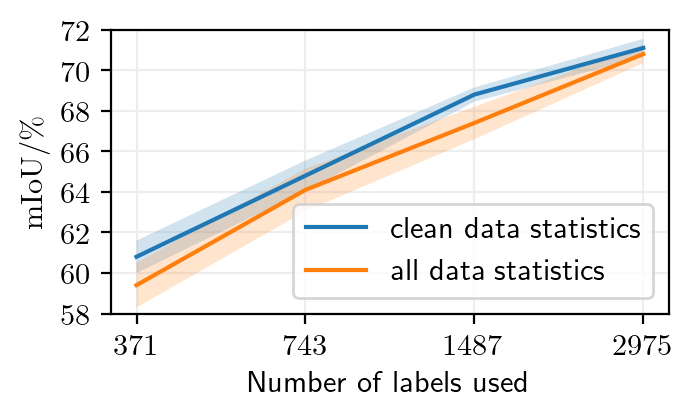

In [20]:
name_to_values = {
    r"clean data statistics":
        [ms(60.8, 1.6), ms(64.8, 1.5), ms(68.8, 0.7),
         ms(71.1, 0.9)],
    r"all data statistics": [ms(59.4, 2.2),
                                      ms(64.1, 2.1),
                                      ms(67.4, 1.6),
                                      ms(70.8, 0.9)], }
name_to_style = {
    r"clean data statistics": dict(color='C0'),
    r"all data statistics": dict(color='C1'), }

fig = plot_label_subsets(name_to_values, name_to_style, ylim=[58, 72], legend_loc='lower right', w_mult=0.7, h_mult=0.7)
fig.savefig('./data/plots/cs-half-ablation-bn-stats-upd.pdf')

### Cityscapes

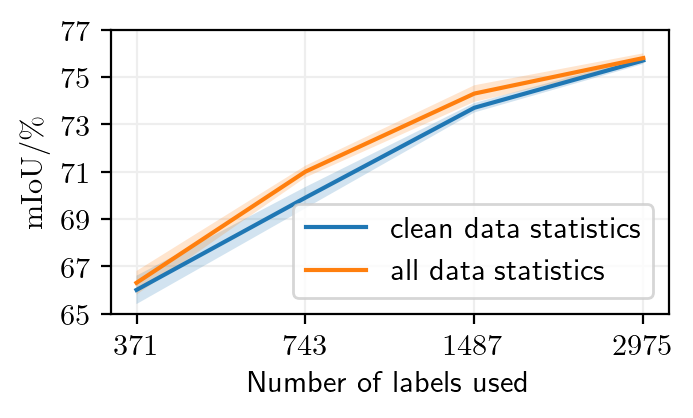

In [24]:
name_to_values = {
    r"clean data statistics":
        [ms(66.0, 1.2), ms(69.9, 0.9), ms(73.7, 0.4),
         ms(75.7, 0.3)],
    r"all data statistics": [ms(66.3, 1.0),
                                     ms(71.0, 0.5),
                                     ms(74.3, 0.7),
                                     ms(75.8, 0.4)], }
name_to_style = {
    r"clean data statistics": dict(color='C0'),
    r"all data statistics": dict(color='C1'), }

fig = plot_label_subsets(name_to_values, name_to_style, ylim=[65, 77], legend_loc='lower right', w_mult=0.7, h_mult=0.7)
fig.savefig('./data/plots/cs-ablation-bn-stats-upd.pdf')

### PASCAL VOC

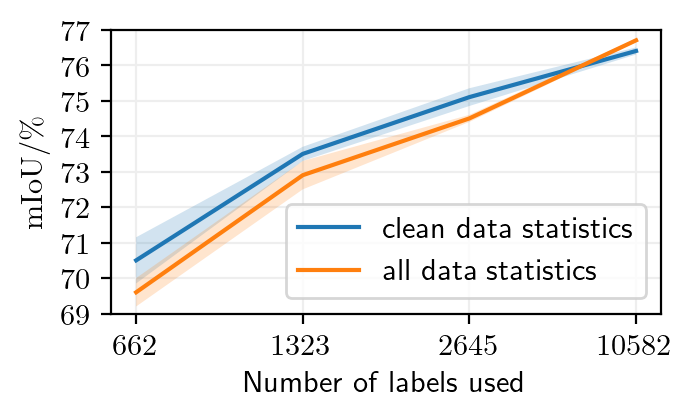

In [25]:
name_to_values = {
    r"clean data statistics":
        [ms(70.5, 1.3),
         ms(73.5, 0.4),
         ms(75.1, 0.5),
         ms(76.4, 0.2)],
    r"all data statistics":
        [ms(69.6, 0.8),
         ms(72.9, 0.8),
         ms(74.5, 0.2),
         ms(76.7, 0.1)], 
}
name_to_style = {
    r"clean data statistics": dict(color='C0'),
    r"all data statistics": dict(color='C1'),
    r"clean data statistics (MT)": dict(color='C0', linestyle='dashed'),
    r"all data statistics (MT)": dict(color='C1', linestyle='dashed'),     
      }

fig = plot_label_subsets(name_to_values, name_to_style, ylim=[69, 77], xticks=['$662$', '$1323$', '$2645$', '$10582$'], legend_loc='lower right', w_mult=0.7, h_mult=0.7)
fig.savefig('./data/plots/pascal-ablation-bn-stats-upd.pdf')

### PASCAL VOC (Mean Teacher)

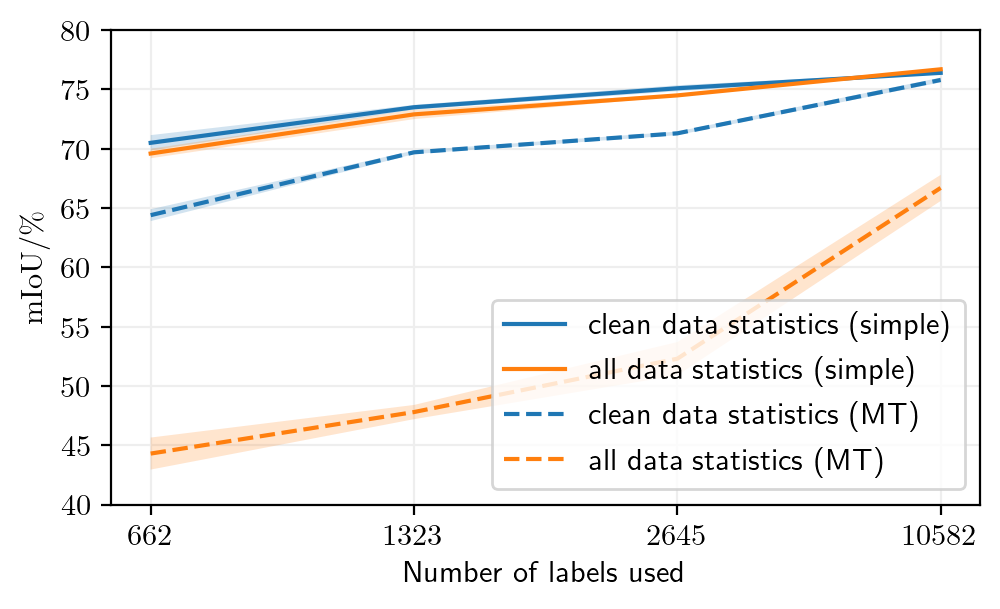

In [23]:
name_to_values = {
    r"clean data statistics (simple)":
        [ms(70.5, 1.3),
         ms(73.5, 0.4),
         ms(75.1, 0.5),
         ms(76.4, 0.2)],
    r"all data statistics (simple)":
        [ms(69.6, 0.8),
         ms(72.9, 0.8),
         ms(74.5, 0.2),
         ms(76.7, 0.1)], 
    r"clean data statistics (MT)":
        [ms(64.4, 1.0),
         ms(69.7, 0.3),
         ms(71.3, 0.3),
         ms(75.8, 0.4)],
    r"all data statistics (MT)":
        [ms(44.3, 2.7),
         ms(47.8, 1.2),
         ms(52.3, 2.8),
         ms(66.7, 2.2)],          
}
name_to_style = {
    r"clean data statistics (simple)": dict(color='C0'),
    r"all data statistics (simple)": dict(color='C1'),
    r"clean data statistics (MT)": dict(color='C0', linestyle='dashed'),
    r"all data statistics (MT)": dict(color='C1', linestyle='dashed'),     
      }

fig = plot_label_subsets(name_to_values, name_to_style, ylim=[40, 80], xticks=['$662$', '$1323$', '$2645$', '$10582$'], legend_loc='lower right', w_mult=1, h_mult=1)
fig.savefig('./data/plots/pascal-mt-ablation-bn-stats-upd.pdf')

### CIFAR-10

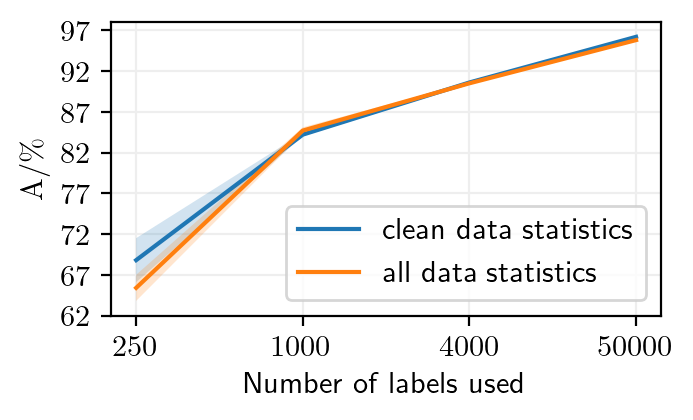

In [26]:
name_to_values = {
    r"clean data statistics":
        [ms(68.8, 5.4), ms(84.2, 0.4), ms(90.6, 0.4),
         ms(96.2, 0.2)],
    r"all data statistics": [ms(65.4, 3.2),
                                     ms(84.7, 0.8),
                                     ms(90.5, 0.2),
                                     ms(95.8, 0.2)], 
                                     }
name_to_style = {
    r"clean data statistics": dict(color='C0'),
    r"all data statistics": dict(color='C1'), }

fig = plot_label_subsets(name_to_values, name_to_style, ylim=[62, 98], xticks=['$250$', '$1000$', '$4000$', '$50000$'], ylabel='$\mathrm{A}/\%$',
                         legend_loc='lower right', w_mult=0.7, h_mult=0.7)
fig.savefig('./data/plots/cifar10-ablation-bn-stats-upd.pdf')

## half-resolution Cityscapes, 1/4 of labels, perturbation strength validation

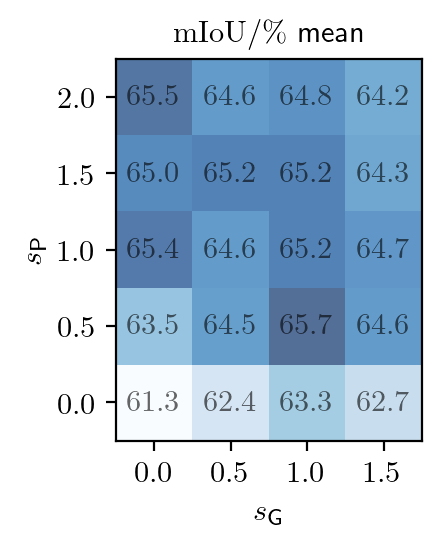

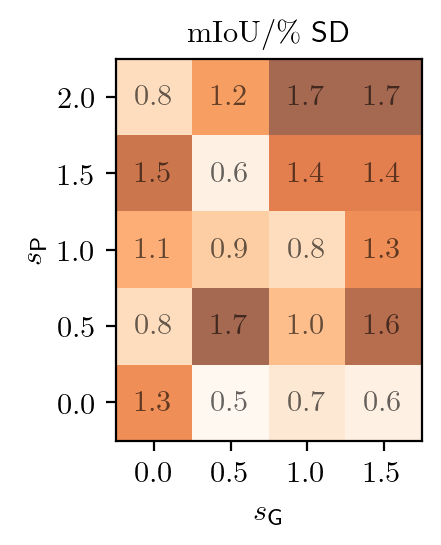

In [17]:
pert_validation_grid_means = np.array([[.613, .624, .633, .627], [.635, .645, .657, .646],
                                       [.654, .646, .652, .647], [.650, .652, .652, .643],
                                       [.655, .646, .648, .642]]) * 100
pert_validation_grid_stdevs = np.array([[.013, .005, .007, .006], [.008, .017, .010, .016],
                                        [.011, .009, .008, .013], [.015, .006, .014, .014],
                                        [.008, .012, .017, .017]]) * 100


def plot_grid(matrix, xticks, yticks, xlabel, ylabel, cmap='RdYlGn', title=None, center_cmap=False):
    w, h = get_figsize(0.9 * 0.9)

    fig, ax = plt.subplots(figsize=(h, h))

    mean = matrix.mean()

    ax.matshow(matrix - mean if center_cmap else matrix, cmap=cmap, alpha=0.7)

    for i in range(matrix.shape[1]):
        for j in range(matrix.shape[0]):
            c = matrix[j, i]
            ax.text(i, j, f"${c:.1f}$".lstrip('0'), va='center', ha='center',
                    weight='semibold', color='black', alpha=0.6)
    plt.xticks(range(matrix.shape[1]), xticks)  #, rotation=90)
    plt.yticks(range(matrix.shape[0]), yticks)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    ax.invert_yaxis()
    ax.xaxis.set_ticks_position("bottom")
    #ax.xaxis.set_label_position("top")
    fig.tight_layout()
    return fig


xticks = [f'${i * 0.5:.1f}$' for i in range(4)]
yticks = [f'${i * 0.5:.1f}$' for i in range(5)]
fig = plot_grid(pert_validation_grid_means, xticks=xticks, yticks=yticks, xlabel=r"$s_\text{G}$",
                ylabel=r"$s_\text{P}$", center_cmap=False, cmap='Blues', title="$\mathrm{mIoU}/\%$ mean")
fig.savefig('./data/plots/cs-half-pert-validation-grid.pdf', bbox_inches='tight')
fig = plot_grid(pert_validation_grid_stdevs, xticks=xticks, yticks=yticks, xlabel=r"$s_\text{G}$",
                ylabel=r"$s_\text{P}$", cmap='Oranges', title="$\mathrm{mIoU}/\%$ SD")
fig.savefig('./data/plots/cs-half-pert-validation-grid-stds.pdf', bbox_inches='tight')

In [18]:
def handler(state):
    def _generate_results(results, class_colors, dir="/tmp/semisup", common_prefix="",
                          common_suffix="", method_suffix=""):
        import vidlu.utils.presentation.visualization as vis
        import vidlu.transforms.image as vti

        if common_prefix != "":
            common_prefix = f"{common_prefix}_"
        if common_suffix != "":
            common_suffix = f"_{common_suffix}"
        if method_suffix != "":
            method_suffix = f"_{method_suffix}"
        dir = Path(dir)

        results = {
            k: v.argmax(1) if k.startswith('out') else v
            for k, v in results.items() if k.startswith('x') or k.startswith('out')}
        results = {k: v.detach().cpu() for k, v in results.items()}
        results = {
            k: (vti.chw_to_hwc(v.clamp(0, 1)) if v.shape[1] == 3 else v).numpy()
            for k, v in results.items()}

        colors = vis.normalize_colors(class_colors, insert_zeros=True)
        for k, v in results.items():
            if v.shape[-1] != 3:
                v = vis.colorize_segmentation(v + 1, colors)
            ims = [vti.numpy_to_pil((im * 255).astype(np.uint8)) for im in v]
            for i, im in enumerate(ims):
                path = dir / f"{common_prefix}{i:04}_{k}{common_suffix}.png"
                print(path)
                im.save(path)

        return results

    from vidlu.data.datasets import Cityscapes
    if state.iteration == 0:
        _generate_results(dir='/mnt/sdc1/igrubisic/semisup',
                          class_colors=Cityscapes.info.class_colors, results=state.result,
                          common_prefix=f"{state.epoch:04}_{state.iteration:03}")


trainer.training.iter_completed.add_handler(handler)
#from vidlu.utils.debug import state as ctx
#key = 'trainingfig'
#if key not in ctx:
#   ctx[key] = dict(sup=state.batch[0].name, semisup=state.batch[1].name)


NameError: name 'trainer' is not defined